# Exploration of airport delay data

This notebook aims predict day-ahead delays at US airport(s) based on historical delays and various other features.

Sections:
- Download Data Locally
- Cleaning, Feature Engineering and Encoding 
- Feed-forward Deep Learning Model
- Conclusion

## Download data locally

- The following script downloads flight data CSVs and merges everything into a Dataframe
- Two CSVs are generated to act as a cache to stop re-download on execution
- To collect the newest data, delete existing CSVs

In [179]:
from azure.storage.blob import BlobServiceClient
import pandas as pd
import io
import os

# Your connection string
connect_str = ""
# Create the BlobServiceClient object
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

# Get a reference to the container
container_client = blob_service_client.get_container_client("aviation499")


def get_df(arrive_departure, csv_filename):
    # Check if the CSV file already exists
    if os.path.exists(csv_filename):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(csv_filename)
    else:
        blob_list = container_client.list_blobs(name_starts_with=arrive_departure)
        combined_df = pd.DataFrame()

        # Iterate over each blob in the folder
        for blob in blob_list:
            # Check if the blob is a CSV file
            if blob.name.endswith(".csv"):
                # Download the CSV file
                blob_data = container_client.get_blob_client(blob.name).download_blob().readall()
                
                # Convert the blob data to a DataFrame
                df = pd.read_csv(io.StringIO(blob_data.decode("utf-8")))
                
                # Extract the airport name and date from the blob name
                _, date, airport_name = blob.name.split("/")
                df['Date'] = date
                
                combined_df = pd.concat([combined_df, df], ignore_index=True)
        
        # Save the combined DataFrame as a CSV file
        combined_df.to_csv(csv_filename, index=False)
        
        # Assign the DataFrame to the variable
        df = combined_df
    
    return df

# Get the arrivals and departures data as DataFrame
combined_df_arrivals = get_df("arrivals", "arrivals.csv")
combined_df_departures = get_df("departures", "departures.csv")


# Add 'arrivals_departures' column to DataFrames and label
combined_df_arrivals['arrivals_departures'] = 0
combined_df_departures['arrivals_departures'] = 1

# Concatenate the arrivals and departures dataframes
combined_df = pd.concat([combined_df_arrivals, combined_df_departures])

# Reset the index of the combined dataframe
combined_df = combined_df.reset_index(drop=True)

# Print the head of the arrivals and departures data
print(combined_df.head())


             origin arrive_depart  \
0  Las Vegas\n(LAS)      12:06 am   
1    Orlando\n(MCO)      12:10 am   
2      Miami\n(MIA)      12:10 am   
3   New York\n(JFK)      12:13 am   
4     Dallas\n(DAL)      12:27 am   

                                           flight  \
0                                           DL707   
1                                          WN1326   
2                                          F92337   
3  DL1248\nAZ3401\nKL5031\nUX3424\nVS4817\nWS7756   
4                                           CHR10   

                                             airline terminal  \
0                                    Delta Air Lines        S   
1                                 Southwest Airlines        N   
2                                  Frontier Airlines        N   
3  Delta Air Lines\nITA Airways\nKLM Royal Dutch ...        S   
4                                 Chairman Airmotive      NaN   

                 status airport_code              Ingestion Date   

## Cleaning, Feature Engineering and Encoding 

- Find null values
- Drop redundant columns,
- Value counts for flight status code - diverted and cancelled become delayed, landed is on time (everything is disruption)

In [180]:
# Find and count null values
arrivals_null_counts = combined_df.isnull().sum()
print("Null value counts in arrivals:")
print(arrivals_null_counts)

Null value counts in arrivals:
origin                     0
arrive_depart              0
flight                     0
airline                   87
terminal               74972
status                     0
airport_code               0
Ingestion Date             0
Date                       0
arrivals_departures        0
dtype: int64


In [181]:
# Drop the specified columns - not used
combined_df = combined_df.drop(['flight', 'arrive_depart','terminal','Ingestion Date'], axis=1)

print(combined_df.head())

             origin                                            airline  \
0  Las Vegas\n(LAS)                                    Delta Air Lines   
1    Orlando\n(MCO)                                 Southwest Airlines   
2      Miami\n(MIA)                                  Frontier Airlines   
3   New York\n(JFK)  Delta Air Lines\nITA Airways\nKLM Royal Dutch ...   
4     Dallas\n(DAL)                                 Chairman Airmotive   

                 status airport_code      Date  arrivals_departures  
0  Landed - On-time [+]          ATL  20230512                    0  
1  Landed - On-time [+]          ATL  20230512                    0  
2  Landed - Delayed [+]          ATL  20230512                    0  
3  Landed - On-time [+]          ATL  20230512                    0  
4  Landed - On-time [+]          ATL  20230512                    0  


In [182]:
# Find unique status types
arrivals_status_counts = combined_df['status'].value_counts()
print("Unique status types and counts:\n")
print(arrivals_status_counts)

Unique status types and counts:

status
Landed - On-time [+]     598397
Landed - Delayed [+]     198885
Landed - DIVERTED [+]      4538
Landed [+]                   20
Name: count, dtype: int64


In [183]:
# Define a mapping dictionary for encoding the status values
status_mapping = {
    'Landed - On-time [+]': 0,
    'Landed [+]': 0,
    'Landed - Delayed [+]': 1,
    'Landed - DIVERTED [+]': 1
}

# Encode the "status" column in the arrivals DataFrame
combined_df['status_encoded'] = combined_df['status'].map(status_mapping)

### Format origin column for airport

In [184]:
# Create the new column 'origin_code' which contains the 3 letter airport code
combined_df['origin_departure_code'] = combined_df['origin'].str.split('\n').str[1].str.strip('()')

combined_df['origin_departure_code']


0         LAS
1         MCO
2         MIA
3         JFK
4         DAL
         ... 
801835    CMH
801836    FLL
801837    DFW
801838    MEM
801839    FLL
Name: origin_departure_code, Length: 801840, dtype: object

### Format Date and remove code sharing airlines

In [185]:
# Convert the "Date" column in the arrivals DataFrame to datetime type

combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%Y%m%d')


# Removing code sharing parnters from airline column
# First airline in string is the airline itself - creating new column with only first

combined_df['airline'] = combined_df['airline'].str.split('\n').str.get(0)

### Feature selection and encoding

- Season
- Federal public holiday
- Day of the week
- delay percentage 0 day prior (target predictor)
- delay percentage 1 day prior
- delay percentage 2 day prior
- delay percentage 3 day prior
- delay percentage 5 day prior
- airport_code

### Seasonal feature
Labelled 0,1,2,3 for Spring, Summer, Autumn, and Winter

In [186]:

# Create a new column "season" and initialize with -1
combined_df['season'] = -1

# Define the criteria for each season based on month ranges
season_mapping = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

# Iterate over each row and assign the corresponding season
for index, row in combined_df.iterrows():
    month = row['Date'].month
    for season, months in season_mapping.items():
        if month in months:
            # Map the season to numerical values (0, 1, 2, 3)
            combined_df.at[index, 'season'] = list(season_mapping.keys()).index(season)
            break


### Public holiday feature
Binary - 0 no, 1 yes

In [187]:

# Predefined list of public holidays in the US
public_holidays = ['2023-01-01', '2023-01-16', '2023-02-20', '2023-05-29', '2023-07-04', '2023-09-04', '2023-10-09', '2023-11-10', '2023-11-23', '2023-12-25']

# Convert the "Date" column to datetime type if it's not already
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Create a new column "public_holiday" and initialize with 0
combined_df['public_holiday'] = 0

# Set the value to 1 if the date is in the public holidays list
combined_df.loc[combined_df['Date'].dt.strftime('%Y-%m-%d').isin(public_holidays), 'public_holiday'] = 1


### Day of week feature
Mon to Sun labelled as 0 to 6

In [188]:
# Convert the "Date" column to datetime if it's not already in that format
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Add a new column for the day of the week
combined_df['Day of Week'] = combined_df['Date'].dt.dayofweek


### Delay look back feature
Labels each day by the ratio (0-1) of delayed flights (delayed/all) looking back 1,2,3 and 5 days. delays_0 is the target.

In [189]:
# Delay look back features

# Deys looking back
lookback_periods = [0, 1, 2, 3, 5]

# Generate respective columns
for lookback in lookback_periods:
    column_name = f'delays_{lookback}'
    combined_df[column_name] = 0

# Get the unique dates in the DataFrame
unique_dates = combined_df['Date'].unique()

# Loop through each unique date
for date in unique_dates:
    # Loop through a range of lookback days
    for lookback in [0, 1, 2, 3, 5]:
        # Compute the lookback date
        lookback_date = date - pd.DateOffset(days=lookback)
        
        # Filter the DataFrame for the lookback date
        lookback_data = combined_df[combined_df['Date'] == lookback_date]
        
        # Compute the delay proportion for the lookback period
        record_count = len(lookback_data)
        delay_count = len(lookback_data[lookback_data['status_encoded'] == 1])
        
        # Compute the delay proportion
        delay_proportion = delay_count / record_count if record_count > 0 else 0
        
        # Update the corresponding rows in the delays columns
        combined_df.loc[combined_df['Date'] == date, f'delays_{lookback}'] = delay_proportion


# Remove the rows of the first 5 days - corrects feature - lookback 5 days
combined_df = combined_df[combined_df['Date'] > combined_df['Date'].unique()[4]]

### Simplifying Dataframe
Now that the most important feature (lookback) is calculated, non unique combinations of airport_code, Date, and arrivals_departure are dropped to lower the compute requirements of the model. This makes the encoded features encoded_airport_codes and encoded_airlines irrelevant. These features will be useful for a future model.

In [190]:
combined_df = combined_df.drop_duplicates(subset=['airport_code', 'Date','arrivals_departures'])

### Encoding origin_code, airport_code and airline
Using one-hot for these categorical variables. Note that only airport_code is the feature implemented as the others are, the others will be used for a more complex model once more data is gathered. 



In [191]:
# Encode origin airport, airline One-Hot encoding

import tensorflow as tf
import numpy as np

# Get the unique origin values from the 'origin' column
origins = combined_df['origin_departure_code'].unique()

# Create a dictionary to map each origin value to an index
origin_to_index = {origin: index for index, origin in enumerate(origins)}

# Encode the 'origin' column using one-hot encoding
encoded_origins = tf.one_hot(
    tf.constant([origin_to_index[origin] for origin in combined_df['origin_departure_code']]),
    depth=len(origins)
)

# Convert the encoded origins to a numpy array
encoded_origins = np.array(encoded_origins)

# Get the unique airport code values from the 'airport_code' column
airport_codes = combined_df['airport_code'].unique()

# Create a dictionary to map each airport code value to an index
airport_code_to_index = {airport_code: index for index, airport_code in enumerate(airport_codes)}

# Encode the 'airport_code' column using one-hot encoding
encoded_airport_codes = tf.one_hot(
    tf.constant([airport_code_to_index[airport_code] for airport_code in combined_df['airport_code']]),
    depth=len(airport_codes)
)

# Convert the encoded airport codes to a numpy array
encoded_airport_codes = np.array(encoded_airport_codes)

# Get the unique airline values from the 'airline' column
airlines = combined_df['airline'].unique()

# Create a dictionary to map each airline value to an index
airline_to_index = {airline: index for index, airline in enumerate(airlines)}

# Encode the 'airline' column using one-hot encoding
encoded_airlines = tf.one_hot(
    tf.constant([airline_to_index[airline] for airline in combined_df['airline']]),
    depth=len(airlines)
)

# Convert the encoded airlines to a numpy array
encoded_airlines = np.array(encoded_airlines)

# Print the shape of the encoded arrays
print("Encoded origins_code shape:", encoded_origins.shape)
print("Encoded airport codes shape:", encoded_airport_codes.shape)
print("Encoded airlines shape:", encoded_airlines.shape)

Encoded origins_code shape: (2408, 194)
Encoded airport codes shape: (2408, 28)
Encoded airlines shape: (2408, 113)


### Preparing features

In [192]:
# Specify the feature columns
feature_columns = ['delays_1', 'delays_2', 'delays_3', 'delays_5', 'season', 'public_holiday', 'Day of Week','arrivals_departures']

# Extract the existing features as a NumPy array
existing_features = combined_df[feature_columns].to_numpy()

# Concatenate the existing features with the one-hot encoded features
all_features = np.concatenate((existing_features, encoded_airport_codes,), axis=1)

# Print the shape of the merged features array
print("Merged features shape:", all_features.shape)


Merged features shape: (2408, 36)


## Feed-forward Deep Learning Model

The model predicts the day-ahead proportion of flights which are delayed at all airports in aggregate, and individual airports. 

In [193]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
target = combined_df['delays_0'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(all_features, target, test_size=0.2, random_state=42)

# Create a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(all_features.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])
model.compile(optimizer="adam", loss='mean_squared_error',)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))



Epoch 1/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0062
Epoch 2/10
61/61 [==============================] - 0s 1ms/step - loss: 0.0180 - val_loss: 0.0058
Epoch 3/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 0.0047
Epoch 4/10
61/61 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0043
Epoch 5/10
61/61 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 6/10
61/61 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 7/10
61/61 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 8/10
61/61 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 9/10
61/61 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 10/10
61/61 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0023


### Model performance - all airports

In [194]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

# Make predictions
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse_all_airports = mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE): {:.4f}'.format(mse_all_airports))

#Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse_all_airports)
print('Root Mean Squared Error (RMSE): {:.4f}'.format(rmse))

# Calculate Mean Absolute Error (MAE)
mae_all_airports = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE): {:.4f}'.format(mae_all_airports))

# Calculate R-squared (R2) Score
r2_score = r2_score(y_test, y_pred)
print('R-squared (R2) Score: {:.4f}'.format(r2_score))

# Calculate Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred)
print('Explained Variance Score: {:.4f}'.format(explained_variance))


16/16 [==============================] - 0s 800us/step - loss: 0.0023
Test Loss: 0.0022791149094700813
16/16 [==============================] - 0s 733us/step
Mean Squared Error (MSE): 0.0023
Root Mean Squared Error (RMSE): 0.0477
Mean Absolute Error (MAE): 0.0373
R-squared (R2) Score: 0.7175
Explained Variance Score: 0.7524


### Model performance - individual airports

In [195]:
# Get unique airports
unique_airports = combined_df['airport_code'].unique()


# Initialize lists to store MSE and MAE for each airport
mse_scores = []
mae_scores = []

# Iterate over each airport
for airport in unique_airports:

    X_airport = np.concatenate((combined_df['airport_code'].values.reshape(-1, 1), combined_df['delays_0'].values.reshape(-1, 1), all_features), axis=1)
    X_airport = X_airport[X_airport[:, 0] == airport]
    y_airport = X_airport[:, 1]
    X_airport = X_airport[:, 2:]
    X_airport = X_airport.astype(np.float32)

    # Make predictions for the airport
    y_pred_airport = model.predict(X_airport)
    
    # Calculate MSE and MAE for the airport
    mse = mean_squared_error(y_airport, y_pred_airport)
    mae = mean_absolute_error(y_airport, y_pred_airport)
    
    # Append scores to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)

# Print MSE and MAE for each airport
for i, airport in enumerate(unique_airports):
    print(f"Airport: {airport}")
    print(f"MSE: {mse_scores[i]}")
    print(f"MAE: {mae_scores[i]}")
    print()

3/3 [==============================] - 0s 1ms/step
Airport: ATL
MSE: 0.0018622750074594456
MAE: 0.033925135501906394

Airport: AUS
MSE: 0.0024833971559412265
MAE: 0.0390989755526886

Airport: BNA
MSE: 0.0013937952793967253
MAE: 0.02947789699400577

Airport: BOS
MSE: 0.0031151582886978753
MAE: 0.04551429035658255

Airport: BWI
MSE: 0.0028007790237114237
MAE: 0.04133099509191757

Airport: CLT
MSE: 0.0029487800940513767
MAE: 0.043775739211624205

Airport: DCA
MSE: 0.0017805806442076626
MAE: 0.03249866000584026

Airport: DEN
MSE: 0.0020555012943246106
MAE: 0.03594881256901342

Airport: DFW
MSE: 0.0017325193948362595
MAE: 0.03394465773105495

Airport: DTW
MSE: 0.0021453033512188026
MAE: 0.03799981324731778

Airport: EWR
MSE: 0.0014871688398305353
MAE: 0.030334732585712135

Airport: FLL
MSE: 0.00275742511681092
MAE: 0.041605826214475616

Airport: IAD
MSE: 0.0027935598591530882
MAE: 0.04267304042814741

Airport: IAH
MSE: 0.0033054948800704093
MAE: 0.04381384969504301

Airport: LAS
MSE: 0.0027

### Plotting errors at airport level

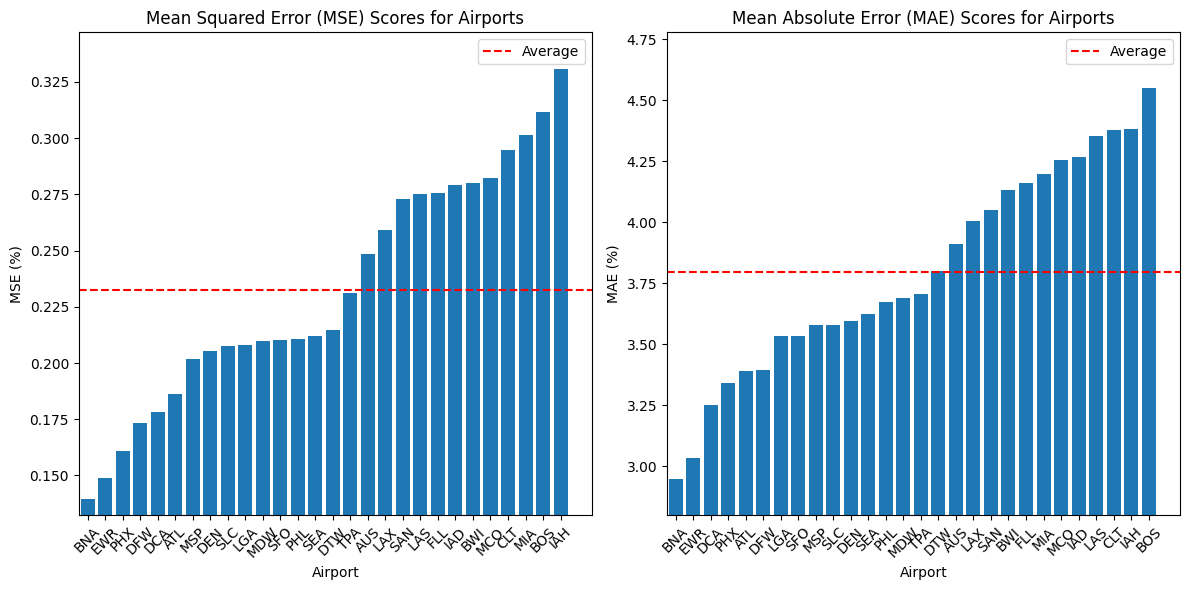

In [196]:
import matplotlib.pyplot as plt

# Rank the airports based on MSE scores
mse_ranks = np.argsort(mse_scores)
# Rank the airports based on MAE scores
mae_ranks = np.argsort(mae_scores)

# Define the positions for the bars
x = np.arange(len(unique_airports))

# Convert the MSE and MAE scores to percentages
mse_scores_pct = np.array(mse_scores) * 100
mae_scores_pct = np.array(mae_scores) * 100

# Sort the scores based on the ranks
mse_scores_sorted = mse_scores_pct[mse_ranks]
mae_scores_sorted = mae_scores_pct[mae_ranks]

# Find the minimum percentage values of MSE and MAE
min_mse_pct = min(mse_scores_sorted)
min_mae_pct = min(mae_scores_sorted)

# Calculate the average MSE and MAE
mse_avg = np.mean(mse_scores) * 100
mae_avg = np.mean(mae_scores) * 100

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot MSE scores
axs[0].bar(x, mse_scores_sorted)
axs[0].set_xticks(x)
axs[0].set_xticklabels(unique_airports[mse_ranks], rotation=45)  # Label with airport codes
axs[0].set_xlabel('Airport')
axs[0].set_ylabel('MSE (%)')
axs[0].set_title('Mean Squared Error (MSE) Scores for Airports')
axs[0].set_ylim(bottom=min_mse_pct*0.95)  # Set the y-axis minimum to min_mse_pct

# Plot MAE scores
axs[1].bar(x, mae_scores_sorted)
axs[1].set_xticks(x)
axs[1].set_xticklabels(unique_airports[mae_ranks], rotation=45)  # Label with airport codes
axs[1].set_xlabel('Airport')
axs[1].set_ylabel('MAE (%)')
axs[1].set_title('Mean Absolute Error (MAE) Scores for Airports')
axs[1].set_ylim(bottom=min_mae_pct*0.95)  # Set the y-axis minimum to min_mae_pct

# Zero the X-axis to the lowest value in both subplots
axs[0].set_xlim(left=-0.5)
axs[1].set_xlim(left=-0.5)

# Add a horizontal line for the average scores
axs[0].axhline(mse_avg, color='r', linestyle='--', label='Average')
axs[1].axhline(mae_avg, color='r', linestyle='--', label='Average')

# Add a legend for the average scores
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


## Conclusion

The model acts as a delay good predictor, considering it has only circa 2 months of data at the time of this commit, with an R2 score of 0.6513 and a low MSE and MAE.

The model will be updated every few weeks with more historical data, and experiment with the features, perhaps adding more. Examples of potential new data-sources/features include:
- weather forecasts at airport level (rain & wind speeds)
- economic data: CPI, ticket-price inflation
- flights per day and ratio of flights per day to runways at each airport
- change Season feature to month/week of year

Other potential variables to predict:
- airlines at each airport and at US level 
- flight numbers